# Thust Wedge Tutorial

Model Setup: Arijit Laik(a.laik@vu.nl)

Revision: Romain Beucher (rbeucher@unimelb.edu.au)

This tutorial is mostly based off Ruh et al. (2013) and other similar stuides, which examine the development thrust sheet and or accretionary wegdes with visco-plastic rheologies .In this 2D model, the boundary conditions, initial conditions,geometry material properties are based on Ruh et al. and other such similar studies.(see Ruh et al. 2013 and references therein: J.B. Ruh, T. Gerya nd J.-P. Burg (2013), G3, v.14(4), p. 1131-1155)

![Tutorial10](./images/Tutorial_10.gif)

In [1]:
import os
import UWGeodynamics as GEO
import numpy as np
import glucifer

/home/arijit/uw/underworld2-mpich/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


loaded rc file /usr/local/lib/python2.7/dist-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


### Model Scaling

In [2]:
u = GEO.UnitRegistry

velocity = 1 * u.centimeter / u.year
model_length = 100. * u.kilometer
bodyforce = 2700. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling["[length]"] = KL
GEO.scaling["[time]"] = Kt
GEO.scaling["[mass]"] = KM

In [3]:
Model = GEO.Model(
    elementRes=(256 , 128),
    minCoord=(0. * u.kilometer, -7 * u.kilometer),
    maxCoord=(128. * u.kilometer, 9. * u.kilometer),
    gravity=(0.0, -9.81 * u.meter / u.second**2))

In [4]:
Model.outputDir = "outputs_tutorial10"

### Material Setup

We will start by defining the air layer, the rigid base and the frictional layer.

In [5]:
air_shape = GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer)
fricLayerShape = GEO.shapes.Layer(top=Model.bottom + 1. * u.kilometer, bottom=Model.bottom + 0.5 * u.kilometer)
rigidBaseShape = GEO.shapes.Layer(top=Model.bottom + 0.5 * u.kilometer, bottom=Model.bottom)
plasticPileShape =  GEO.shapes.Layer(top=0. * u.kilometer, bottom=Model.bottom + 1. * u.kilometer)

air = Model.add_material(name="Air", shape=air_shape)
frictionalBasal = Model.add_material(name="Frictional", shape=fricLayerShape)
rigidBase = Model.add_material(name="Frictional", shape=rigidBaseShape)
plasticPile = Model.add_material(name="Plastic Pile",shape=plasticPileShape)
# sediment = Model.add_material(name="Sediment")

### Pile of sedimentary layers

We define a 6km thick pile of sedimentary layers, with each layer being 0.5 km thick, for a total of 12 layers


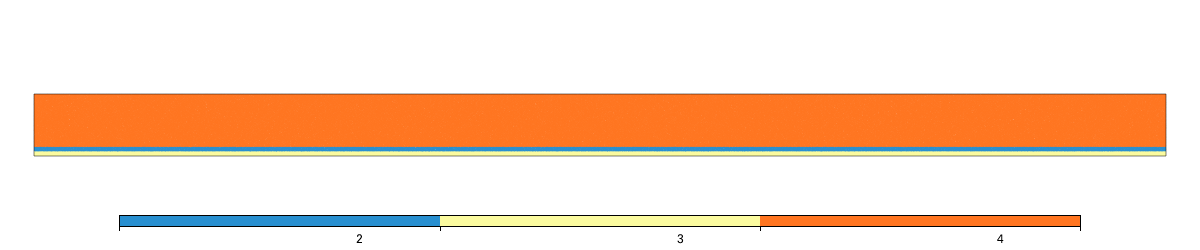

In [6]:
FigMat = glucifer.Figure(figsize=(1200, 250), quality=3)
FigMat.Points(Model.swarm, Model.materialField, 
           discrete=True, 
           fn_mask=Model.materialField > air.index)
FigMat.objects[0].colourBar["binlabels"] = True
FigMat.show()

## Model (Global) properties

In [7]:
Model.density = 2700 * u.kilogram / u.metre**3
Model.viscosity = 1e23 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second
Model.minViscosity = 1e19 * u.pascal * u.second

## Viscosity

In [8]:
air.viscosity = 1e19 * u.pascal * u.second
air.minViscosity = 1e19 * u.pascal * u.second
air.density = 1. * u.kilogram / u.metre**3

# Note that this is not necessary as this does not differ from the
# Model property.

plasticPile.density = 2700 * u.kilogram / u.metre**3
plasticPile.viscosity = 1e23 * u.pascal * u.second
plasticPile.minViscosity = 5e19 * u.pascal * u.second 

frictionalBasal.viscosity = 1e23 * u.pascal * u.second
rigidBase.viscosity = 1e23 * u.pascal * u.second

## Plasticity

In [9]:
plastic_Law = GEO.DruckerPrager(
        cohesion=20. * u.megapascal,
        cohesionAfterSoftening=4. * u.megapascal,
        frictionCoefficient=np.tan(np.radians(25.0)),
        frictionAfterSoftening=np.tan(np.radians(20.0)),
        epsilon1=0.01,
        epsilon2=0.06
    )

plasticPile.plasticity = plastic_Law

frictionalBasal.plasticity = GEO.DruckerPrager(
    cohesion=0.1 * u.megapascal,
    frictionCoefficient=np.tan(np.radians(12.0)),
    frictionAfterSoftening=np.tan(np.radians(6.0)),
    epsilon1=0.01,
    epsilon2=0.06
)

## Velocity Boundary Conditions
The rigid base has the same velocity(=1cm/year,or velocity of the left wall), the linear gradational velocity is in the low frictional layer, this prevents the rigid bottom sheet from bending at the left edge, moreover as the rigid bottom sheet is analogous to a Mylar(PET) conveyor belt / sheet in sandbox models(Konstantinovskaya and Malavieille, 2011[https://doi.org/10.1016/j.tecto.2011.01.020], or Bose et al 2014[https://doi.org/10.1016/j.jsg.2014.07.004]) 
The boundary conditions  simulate the mechanics of convergent plate boundaries where a rigid backstop scrapes upper levels of the crust off a rigid moving “plate”. This is comparable to setups of analog models, where a rough sheet lying below sand layers is pulled out below a fixed and rigid backstop .This setup also matches the boundary conditions used in the analytical critical wedge theory. New swarms coming in through the left side allow for simulation of long term deformation.

![setupandBCs](./images/Tutorial_10_bcs.png)


In [10]:
import underworld.function as fn

tapeL=frictionalBasal
flthick=GEO.nd(tapeL.top-tapeL.bottom)

conditions = [(Model.y <= GEO.nd(rigidBase.top), GEO.nd(-velocity)),
              (Model.y < GEO.nd(tapeL.top),
               GEO.nd(-velocity)*(flthick-(Model.y-GEO.nd(tapeL.bottom)))/flthick),
              (True, GEO.nd(0. * u.centimeter / u.year))]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[fn_condition, 0.],
                      right=[-velocity, None],
                      top=[None, None],
                      bottom=[-velocity, 0.])


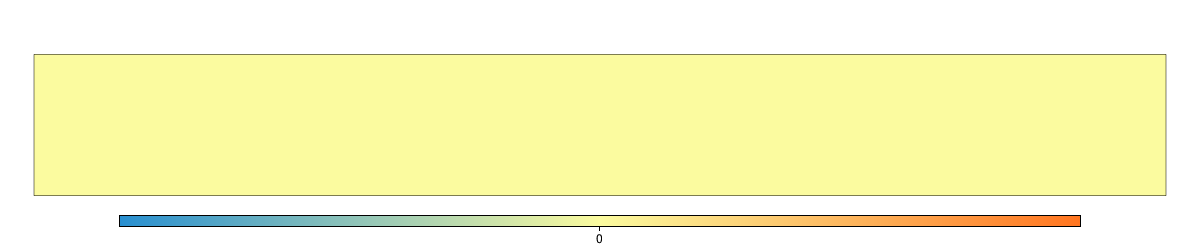

In [11]:
Fig = glucifer.Figure(figsize=(1200, 250), quality=3)
Fig.Surface(Model.mesh, fn.math.dot(Model.velocityField, Model.velocityField))
Fig.show()

In [12]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6
GEO.rcParams["nonlinear.tolerance"] = 1e-3
GEO.rcParams["initial.nonlinear.tolerance"]=1e-5

In [13]:
Model.init_model()


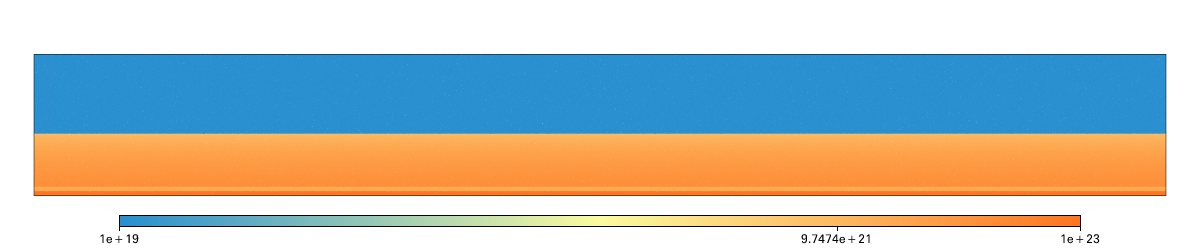

In [14]:
Fig = glucifer.Figure(figsize=(1200, 250), quality=3)
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second), logScale=True)
Fig.show()

In [16]:
passiveLayer=Model.add_swarm_field("hatch")
lThick=GEO.nd(4*Model.height)/Model.mesh.elementRes[1]
passiveLayer.data[:,0]=np.mod(np.round(passiveLayer.swarm.particleCoordinates.data[:,1]/lThick),2)


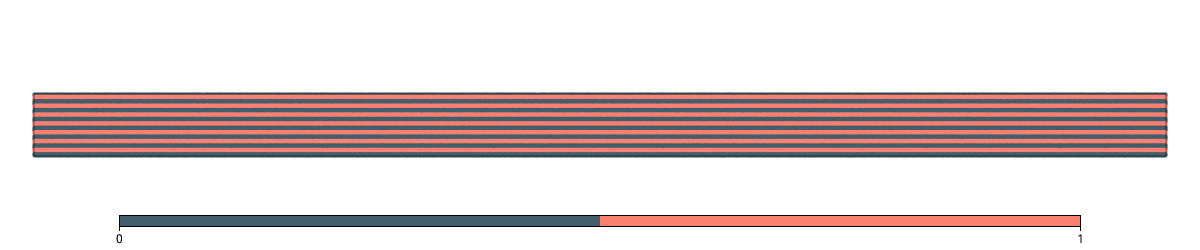

In [17]:
FigPlay = glucifer.Figure(figsize=(1200, 250), quality=3)
FigPlay.Points(Model.swarm,
           passiveLayer,
           pointSize=4.,
           colours='#425e6a salmon',
           discrete=True,fn_mask=Model.materialField > air.index)

FigPlay.show()

In [18]:
def post_solve_hook():
    global FigMat
    if Model.step % 10 == 0:
        FigPlay.save("Material-{0}.png".format(Model.step))
        
Model.postSolveHook = post_solve_hook

In [ ]:
Model.run_for(2.0*u.megayears, checkpoint_interval=0.1 * u.megayear, restartStep=None)

In [ ]:
FigPlay.show()